In [2]:
import pickle
from sklearn.decomposition import PCA
from keras.preprocessing.text import Tokenizer

# Load precomputed splits: equal ratio of female and male theses (no mixed)
splits       = pickle.load( open( "df_splits_equal_m_f.p", "rb" ))

# Load preprocessed documents
docs_train_fun = pickle.load( open( "docs_train_function.p", "rb" ) )
docs_val_fun   = pickle.load( open( "docs_val_function.p", "rb" ) )

docs_train = pickle.load(open( "docs_train_equal_m_f.p", "rb" ) )
docs_val   = pickle.load( open( "docs_val_equal_m_f.p", "rb" ) )

faculties = ['Samhällsvetenskapliga fakulteten', 
                'Handelshögskolan',                  
                'Utbildningsvetenskapliga fakulteten',
                'Sahlgrenska akademin',
                'Humanistiska fakulteten',     
                'IT-fakulteten',
                'Konstnärliga fakulteten',    
                'Naturvetenskapliga fakulteten'  ] 


Using TensorFlow backend.


In [3]:
splits['Y_train'].value_counts()

male      760
female    746
Name: gender_composition, dtype: int64

In [4]:

import pandas as pd

X_train = splits['X_train']
X_val = splits['X_val']

# Separating training and validation data into 8 faculty groups

faculty_splits = [X_train[X_train['faculty'] == fac] for fac in faculties]

faculty_splits_val = [X_val[X_val['faculty'] == fac] 
                        for fac in faculties]

faculty_rows = [[X_train.index.get_loc(i) 
                 for i in fac.index]
                for fac in faculty_splits]

faculty_rows_val = [[X_val.index.get_loc(i) 
                         for i in fac.index] 
                    for fac in faculty_splits_val]


X_train_facs = [(pd.DataFrame([X_train.iloc[i] for i in fac_rows])) for fac_rows in faculty_rows ]

X_val_facs = [(pd.DataFrame([X_val.iloc[i] for i in fac_rows])) for fac_rows in faculty_rows_val ]


docs_train_facs     = [[docs_train[i] for i in fac_row] for fac_row in faculty_rows]
docs_train_fun_facs = [[docs_train_fun[i] for i in fac_row] for fac_row in faculty_rows]


docs_val_facs = [[docs_val[i] for i in val_row] for val_row in faculty_rows_val]
docs_val_fun_facs = [[docs_val_fun[i] for i in val_row] for val_row in faculty_rows_val]

In [5]:
Y_train = splits['Y_train']
Y_val = splits['y_val']

Y_train_facs = [[Y_train.iloc[i] for i in fac_row] for fac_row in faculty_rows]
Y_val_facs   = [[Y_val.iloc[i] for i in fac_row] for fac_row in faculty_rows_val]


In [6]:




# Fit a tokenizer on all training documents
tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs_train)

# Fit a tokenizer on all function word training documents
tokenizer_fun = Tokenizer()
tokenizer_fun.fit_on_texts(docs_train_fun)

# Fit a separate tokenizer on each faculty's training data
tokenizers_fac = []
for docs in docs_train_facs : 
    tok = Tokenizer()
    tok.fit_on_texts(docs)
    tokenizers_fac.append(tok)

# Fit a separate tokenizer on each faculty's function word training data
tokenizers_fun_fac = []
for docs in docs_train_fun_facs : 
    tok = Tokenizer()
    tok.fit_on_texts(docs)
    tokenizers_fun_fac.append(tok)

modes =  ('tfidf','freq','count','binary')

# convert documents to matrices for each encoding mode    
matrices_fac = [[tokenizer.texts_to_matrix(doc,mode=mode) 
                 for mode in modes]
                for doc in docs_train_facs
               ]

matrices_fun_fac = [[tokenizer.texts_to_matrix(doc,mode=mode) 
                 for mode in modes]
                for doc in docs_val_facs
               ]

Xtrain_tfidf, Xtrain_freq, Xtrain_count, Xtrain_binary  = [tokenizer.texts_to_matrix(docs_train,mode=mode) 
                                                               for mode in modes]
                


Xval_tfidf, Xval_freq, Xval_count, Xval_binary  = [tokenizer.texts_to_matrix(docs_val,mode=mode) 
                                                       for mode in modes]


Xtrain_fun_tfidf, Xtrain_fun_freq, Xtrain_fun_count, Xtrain_fun_binary  = [tokenizer_fun.texts_to_matrix(docs_train_fun,mode=mode) 
                                                               for mode in modes]


Xval_fun_tfidf, Xval_fun_freq, Xval_fun_count, Xval_fun_binary  = [tokenizer_fun.texts_to_matrix(docs_val_fun,mode=mode) 
                                                       for mode in modes]
              



In [7]:

# initialize PCA model for each mode
pcas = [PCA(n_components=3) for i in [0,1,2,3]]
pcas_fun = [PCA(n_components=3) for i in [0,1,2,3]]

# Match each pca model with the appropriate training data
pca_train     = list(zip(pcas,[Xtrain_binary,Xtrain_tfidf,Xtrain_count,Xtrain_freq]))
pca_train_fun = list(zip(pcas_fun,[Xtrain_fun_binary,Xtrain_fun_tfidf,Xtrain_fun_count,Xtrain_fun_freq]))


# Match each pca model with the appropriate validation data
pca_val = list(zip(pcas,[Xval_binary,Xval_tfidf,Xval_count,Xval_freq]))

pca_val_fun = list(zip(pcas_fun,[Xval_fun_binary,Xval_fun_tfidf,Xval_fun_count,Xval_fun_freq]))

# Fit each pca model on its corresponding training data
for pca,train in (pca_train   + pca_train_fun) :
    pca.fit(train)

# Transform training and validation data    
pca_binary_train, pca_tfidf_train, pca_count_train, pca_freq_train = [pca.transform(train) for (pca,train) in (pca_train)]

pca_binary_val, pca_tfidf_val, pca_count_val, pca_freq_val = [pca.transform(val) for (pca,val) in (pca_val)]

pca_binary_train_fun, pca_tfidf_train_fun, pca_count_train_fun, pca_freq_train_fun = [pca.transform(train) for (pca,train) in (pca_train_fun)]

pca_binary_val_fun, pca_tfidf_val_fun, pca_count_val_fun, pca_freq_val_fun = [pca.transform(val) for (pca,val) in (pca_val_fun)]

In [8]:
from keras.utils import to_categorical

def gender_to_label(gen) :
    if gen == 'female' : return 0
    elif gen == 'male' : return 1
    else : error 
   
    
train_labels = to_categorical(Y_train.apply(gender_to_label))

train_labels_fac = [[to_categorical(gender_to_label(g)) for g in y ] for y in Y_train_facs]

#test_labels  = to_categorical(y_test.apply(gender_to_label)) 
val_labels   = to_categorical(Y_val.apply(gender_to_label))

val_labels_fac   = [[to_categorical(gender_to_label(g)) for g in y ] for y in Y_val_facs]


train_labels_num = [gender_to_label(item) for item in (Y_train)]
#test_labels_num  = [gender_to_label(item) for item in (y_test)]
val_labels_num   = [gender_to_label(item) for item in (Y_val)]

train_labels_num_fac = [[gender_to_label(item) for item in y] for y in Y_train_facs]
#test_labels_num  = [gender_to_label(item) for item in (y_test)]
val_labels_num_fac   = [[gender_to_label(item) for item in y] for y in Y_val_facs]

def fac_to_int(fac) : 
    facs = {'Samhällsvetenskapliga fakulteten' : 0,
            'Handelshögskolan' : 1,
            'Utbildningsvetenskapliga fakulteten' : 2,
            'Sahlgrenska akademin' : 3,
            'Humanistiska fakulteten' : 4,
            'IT-fakulteten' : 5,
            'Konstnärliga fakulteten' : 6,
            'Naturvetenskapliga fakulteten' : 7
           }
    return facs[fac]

fac_labels_train = [fac_to_int(item) for item in (X_train['faculty'])]


In [9]:
list(set(fac_labels_train))

[0, 1, 2, 3, 4, 5, 6, 7]

In [10]:


Y_by_faculty = [(faculty, (Y_train[X_train['faculty'] == faculty]).value_counts()) for faculty in faculties ]


for (dep,counts) in Y_by_faculty :
    print(dep)
    print(counts)

Samhällsvetenskapliga fakulteten
female    197
male      187
Name: gender_composition, dtype: int64
Handelshögskolan
female    123
male      120
Name: gender_composition, dtype: int64
Utbildningsvetenskapliga fakulteten
male      113
female     93
Name: gender_composition, dtype: int64
Sahlgrenska akademin
male      72
female    64
Name: gender_composition, dtype: int64
Humanistiska fakulteten
female    142
male      131
Name: gender_composition, dtype: int64
IT-fakulteten
female    31
male      29
Name: gender_composition, dtype: int64
Konstnärliga fakulteten
male      66
female    62
Name: gender_composition, dtype: int64
Naturvetenskapliga fakulteten
male      42
female    34
Name: gender_composition, dtype: int64


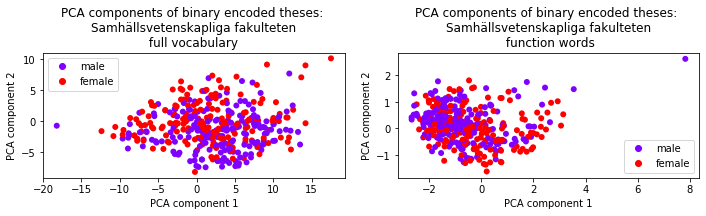

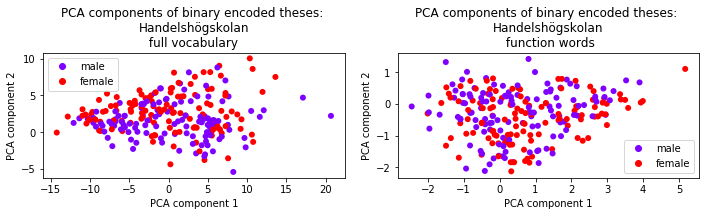

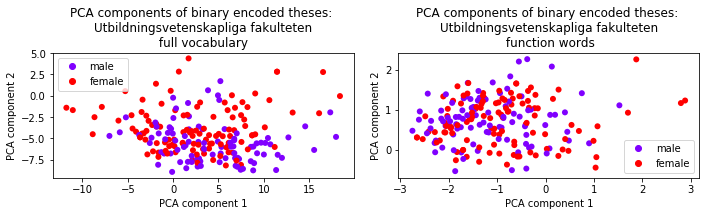

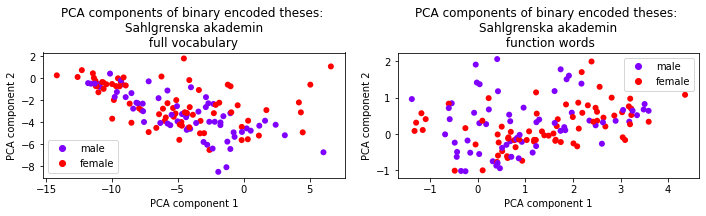

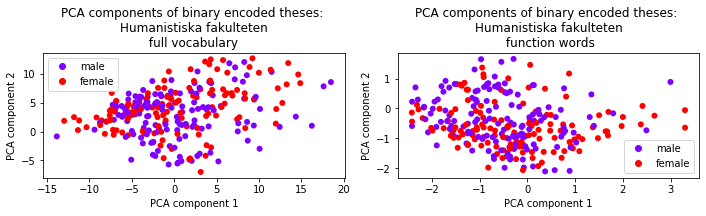

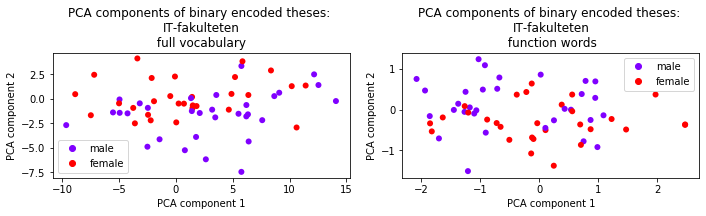

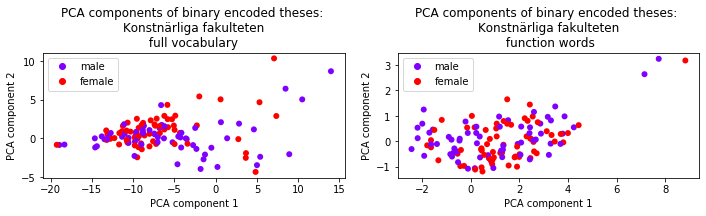

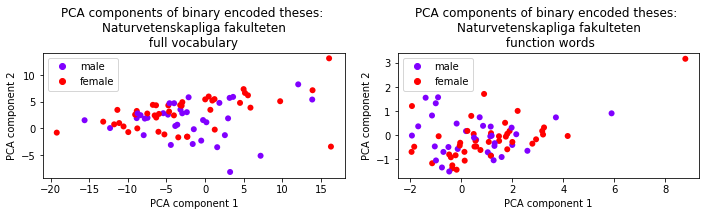

In [11]:
import matplotlib.pyplot as plt

import numpy as np


indices = [[i for i, x in enumerate(fac_labels_train) if x == j] for j in [0,1,2,3,4,5,6,7]]

#pca_binary_train[indices_0,1], pca_binary_train[indices_0,2]

train_labels_i = [[train_labels_num[i] for i in indices[j]] for j in [0,1,2,3,4,5,6,7]]
fac_labels_i   = [[fac_labels_train[i] for i in indices[j]] for j in [0,1,2,3,4,5,6,7]]


classes=['male','female']

classes_fac = ['Samhällsvetenskapliga fakulteten', 
                'Handelshögskolan',                  
                'Utbildningsvetenskapliga fakulteten',
                'Sahlgrenska akademin',
                'Humanistiska fakulteten',     
                'IT-fakulteten',
                'Konstnärliga fakulteten',    
                'Naturvetenskapliga fakulteten'  ] 


def plot_each_faculty(points1,points2,i) : 

    fig = plt.figure(figsize=(10,5))
    plt.subplot(2, 2, 1)
    plt.title('PCA components of binary encoded theses: \n' +  classes_fac[i] + '\n full vocabulary ' )
    scatter1 = plt.scatter(points1[indices[i], 0], points1[indices[i], 2],
            c=train_labels_i[i], edgecolor='none', alpha=1.0,
          
            cmap=plt.cm.get_cmap('rainbow', 3))
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.legend(handles=scatter1.legend_elements()[0], labels=classes)

    plt.subplot(2, 2, 2)
    plt.title('PCA components of binary encoded theses: \n' + classes_fac[i] + '\n function words' )
    scatter1 = plt.scatter(points2[indices[i], 0], points2[indices[i], 2],
            c=train_labels_i[i], edgecolor='none', alpha=1.0,
           # c=train_labels_num, edgecolor='none', alpha=1.0,
            cmap=plt.cm.get_cmap('rainbow', 3))
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.legend(handles=scatter1.legend_elements()[0], labels=classes)



    plt.tight_layout()
    plt.show()

  
    
for i in [0,1,2,3,4,5,6,7] : 
    plot_each_faculty(pca_binary_train,pca_binary_train_fun,i)

In [12]:
import matplotlib.pyplot as plt


def plot_pca_with_encoding(encoding,pca,pca2) :
    fig = plt.figure(figsize=(18,28))
    plt.subplot(6, 2, 1)
    plt.title(encoding + ' encoding: Gender (first and second pca components)')
    scatter = plt.scatter(pca[:, 0], pca[:, 1],
            c=train_labels_num, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('rainbow', 3))
    plt.xlabel('component 1')
    plt.ylabel('component 2')

    plt.legend(handles=scatter.legend_elements()[0], labels=classes)


    plt.subplot(6,2,2)
    plt.title(encoding + ' encoding: Faculty (first and second pca components)')
    scatter = plt.scatter(pca[:, 0], pca[:, 1],
            c=fac_labels_train, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('rainbow', 8))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=classes_fac)
    
    plt.subplot(6,2,3)
    plt.title(encoding + ' encoding: Gender (first and second pca components) \n Function words')
    scatter = plt.scatter(pca2[:, 0], pca2[:, 1],
            c=train_labels_num, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('rainbow', 3))
    plt.xlabel('component 1')
    plt.ylabel('component 2')

    plt.legend(handles=scatter.legend_elements()[0], labels=classes)


    plt.subplot(6,2,4)
    plt.title(encoding + ' encoding: Faculty (first and second pca components) \n Function words')
    scatter = plt.scatter(pca2[:, 0], pca2[:, 1],
            c=fac_labels_train, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('rainbow', 8))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=classes_fac)


    plt.subplot(6, 2, 5)
    plt.title(encoding + ' encoding: Gender (first and third pca components)')
    scatter = plt.scatter(pca[:, 0], pca[:, 2],
            c=train_labels_num, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('rainbow', 3))
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.xlabel('component 1')
    plt.ylabel('component 3')


    plt.subplot(6, 2, 6)
    plt.title(encoding + ' encoding: Faculty (first and third pca components)')
    scatter = plt.scatter(pca[:, 0], pca[:, 2],
            c=fac_labels_train, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('rainbow', 8))
    plt.xlabel('component 1')
    plt.ylabel('component 3')

    plt.legend(handles=scatter.legend_elements()[0], labels=classes_fac)

    plt.subplot(6, 2, 7)
    plt.title(encoding + ' encoding: Gender (first and third pca components) \n Function words')
    scatter = plt.scatter(pca2[:, 0], pca2[:, 2],
            c=train_labels_num, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('rainbow', 3))
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.xlabel('component 1')
    plt.ylabel('component 3')


    plt.subplot(6, 2, 8)
    plt.title(encoding + ' encoding: Faculty (first and third pca components) \n Function words')
    scatter = plt.scatter(pca2[:, 0], pca2[:, 2],
            c=fac_labels_train, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('rainbow', 8))
    plt.xlabel('component 1')
    plt.ylabel('component 3')

    plt.legend(handles=scatter.legend_elements()[0], labels=classes_fac)

    plt.subplot(6,2,9)
    plt.title(encoding + ' encoding: Gender (second and third pca components)')
    scatter = plt.scatter(pca[:, 1], pca[:, 2],
            c=train_labels_num, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('rainbow', 3))
    plt.xlabel('component 2')
    plt.ylabel('component 3')
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)

    plt.subplot(6,2,10)
    plt.title(encoding + ' encoding: Faculty (second and third pca components)')
    scatter = plt.scatter(pca[:, 1], pca[:, 2],
            c=fac_labels_train, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('rainbow', 8))
    plt.xlabel('component 2')
    plt.ylabel('component 3')
    plt.legend(handles=scatter.legend_elements()[0], labels=classes_fac)
    
    
    plt.subplot(6,2,11)
    plt.title(encoding + ' encoding: Gender (second and third pca components) \n Function words')
    scatter = plt.scatter(pca2[:, 1], pca2[:, 2],
            c=train_labels_num, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('rainbow', 3))
    plt.xlabel('component 2')
    plt.ylabel('component 3')
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)

    plt.subplot(6,2,12)
    plt.title(encoding + ' encoding: Faculty (second and third pca components) \n Function words')
    scatter = plt.scatter(pca2[:, 1], pca2[:, 2],
            c=fac_labels_train, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('rainbow', 8))
    plt.xlabel('component 2')
    plt.ylabel('component 3')
    plt.legend(handles=scatter.legend_elements()[0], labels=classes_fac)


    plt.tight_layout()
    plt.show()

    

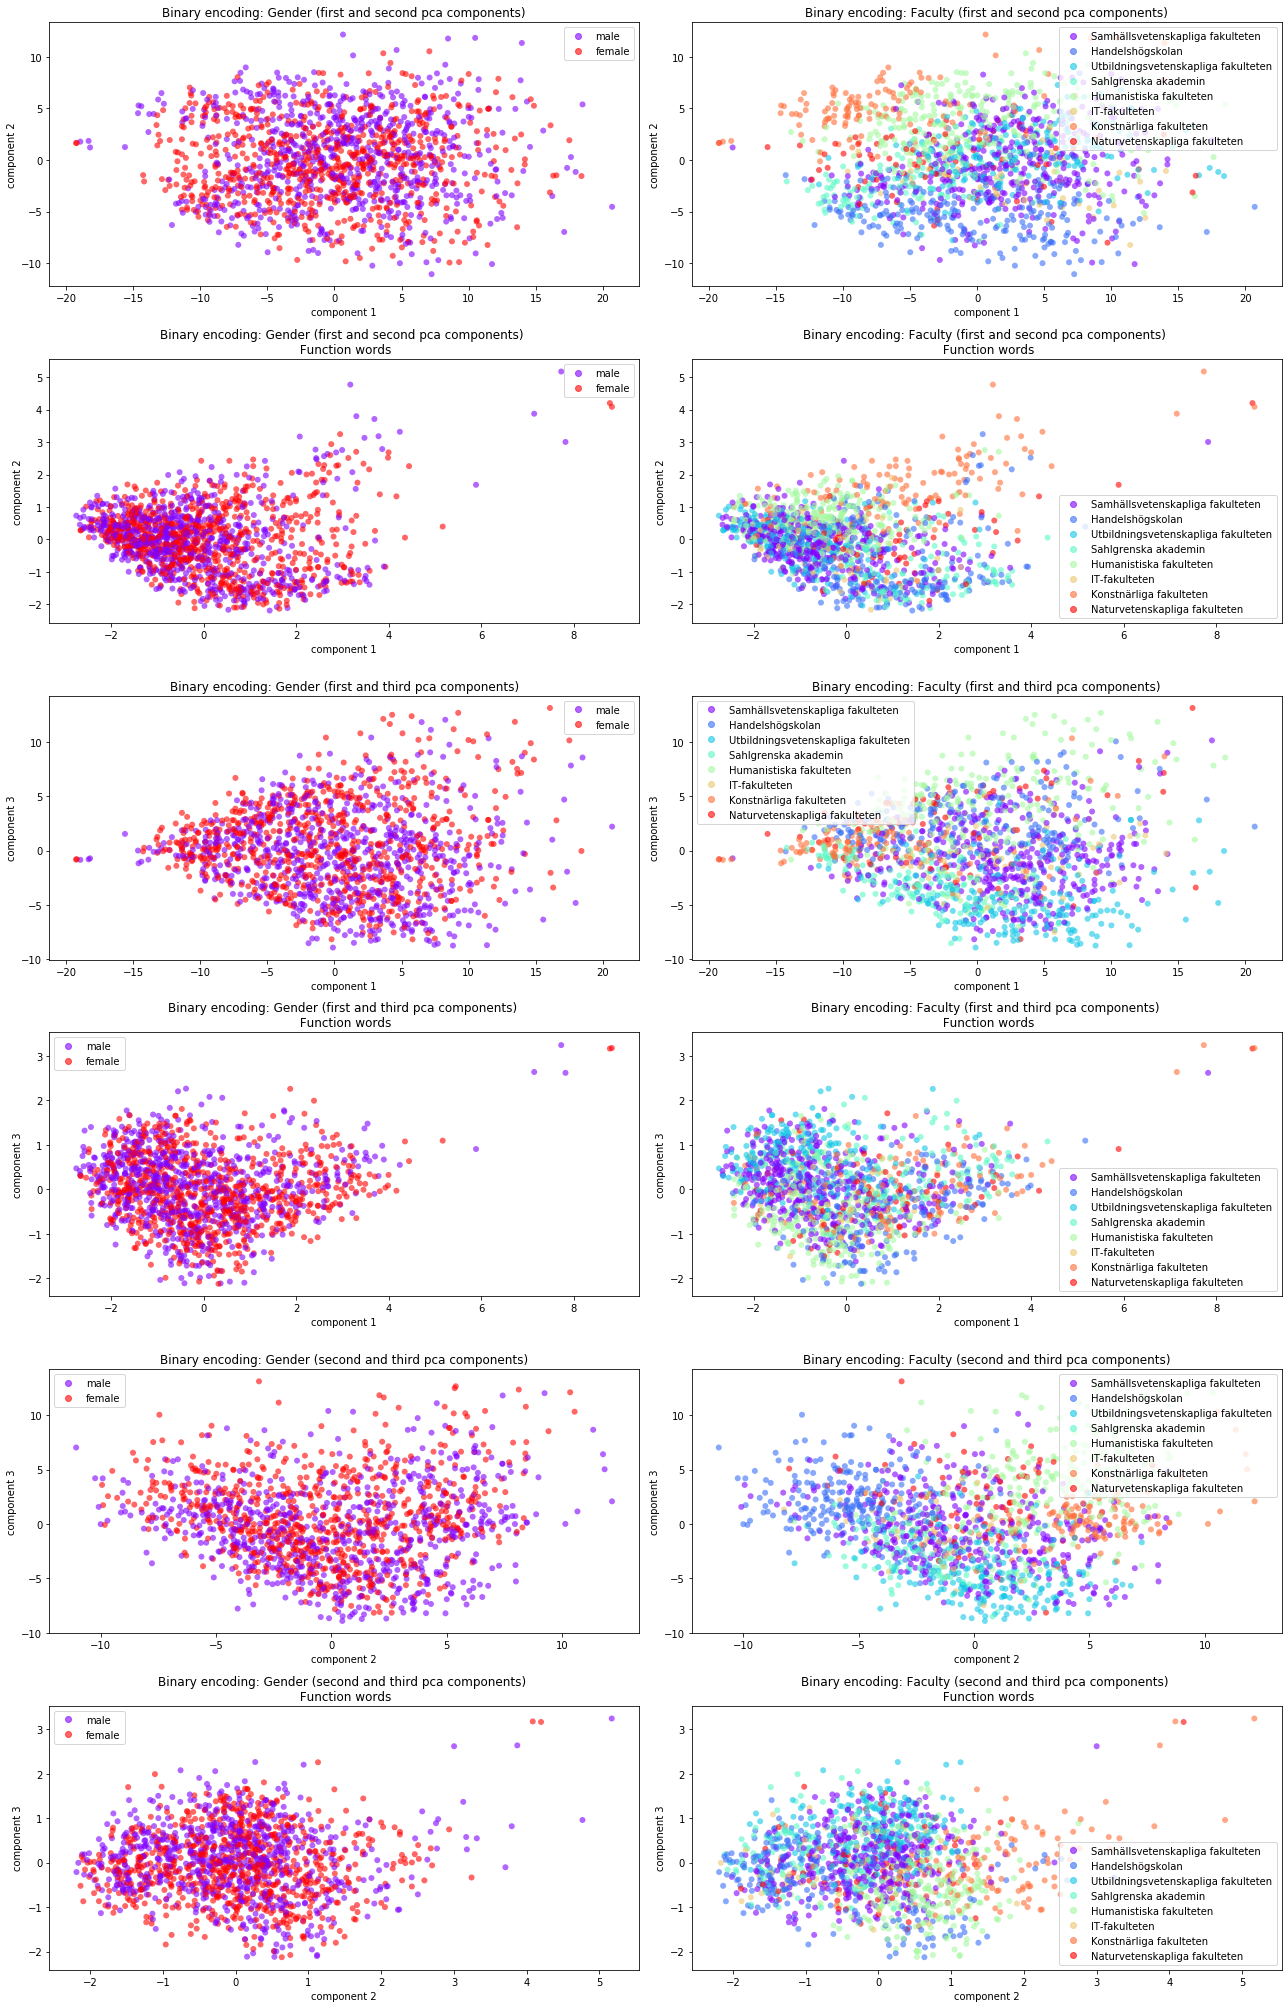

In [13]:
plot_pca_with_encoding('Binary',pca_binary_train,pca_binary_train_fun)



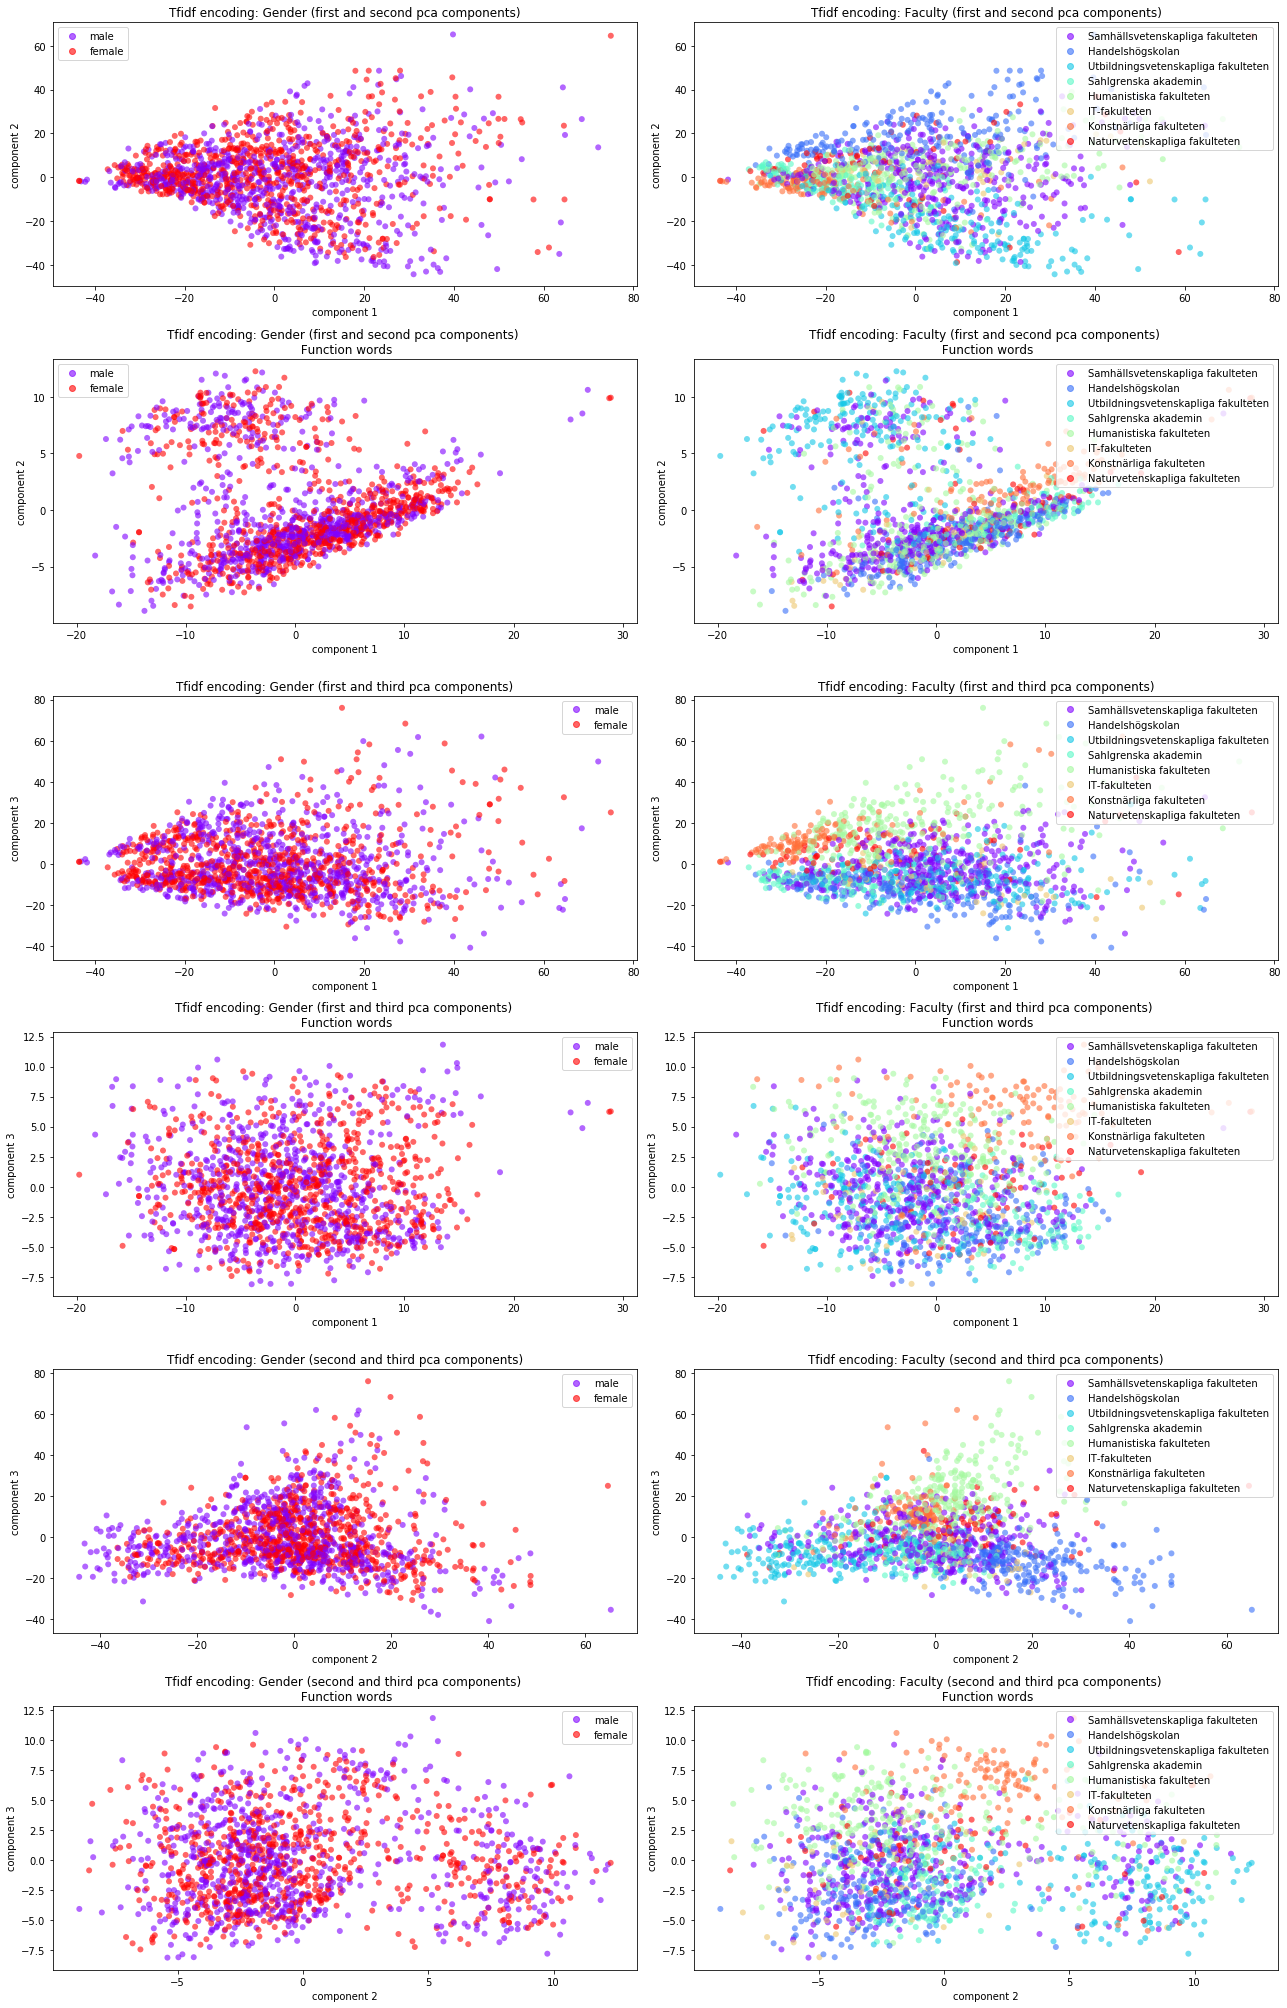

In [14]:

plot_pca_with_encoding('Tfidf',pca_tfidf_train,pca_tfidf_train_fun)


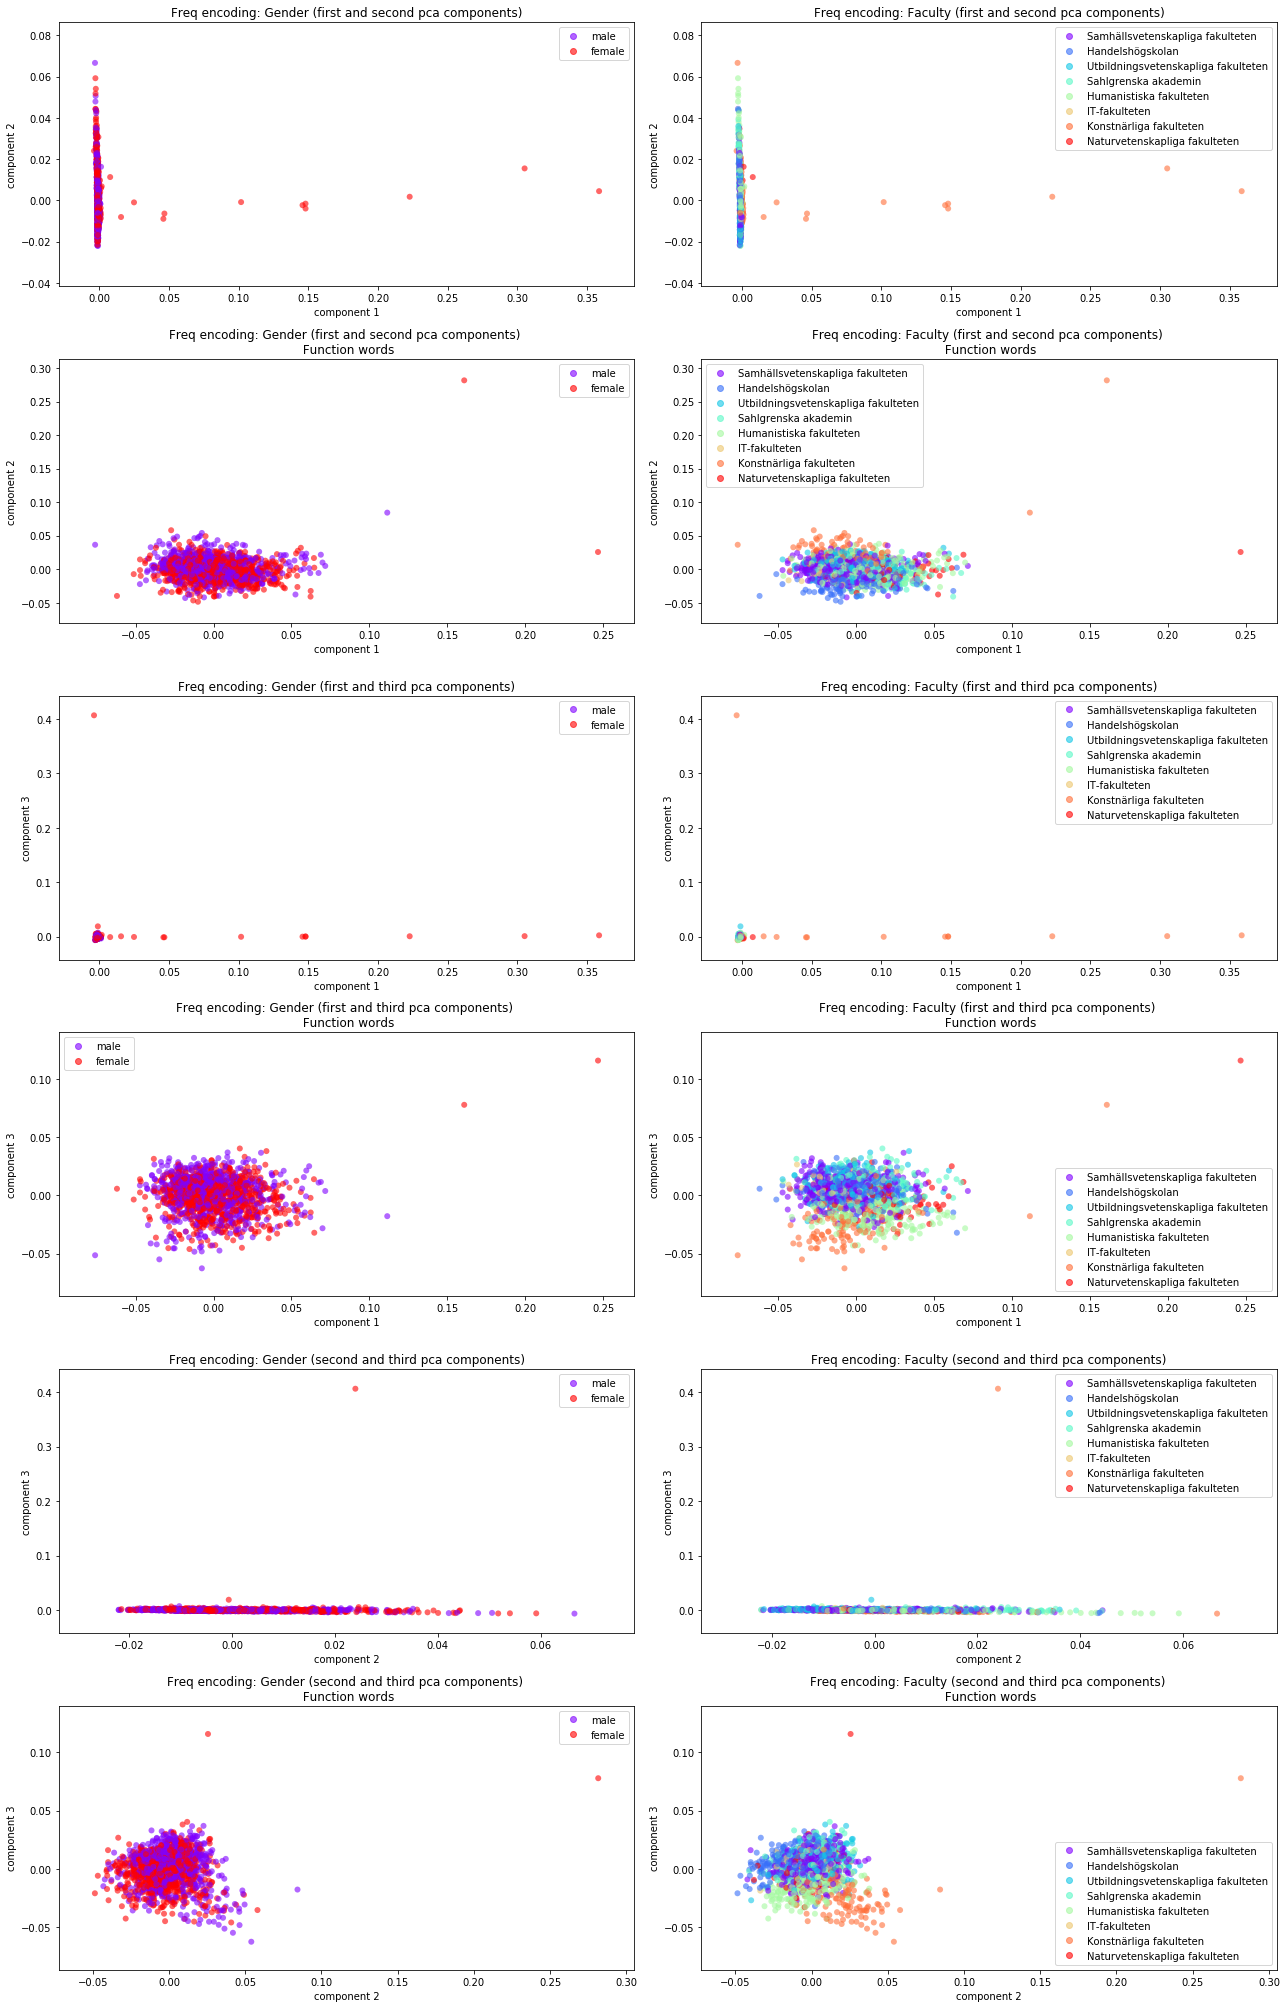

In [15]:
plot_pca_with_encoding('Freq',pca_freq_train,pca_freq_train_fun)

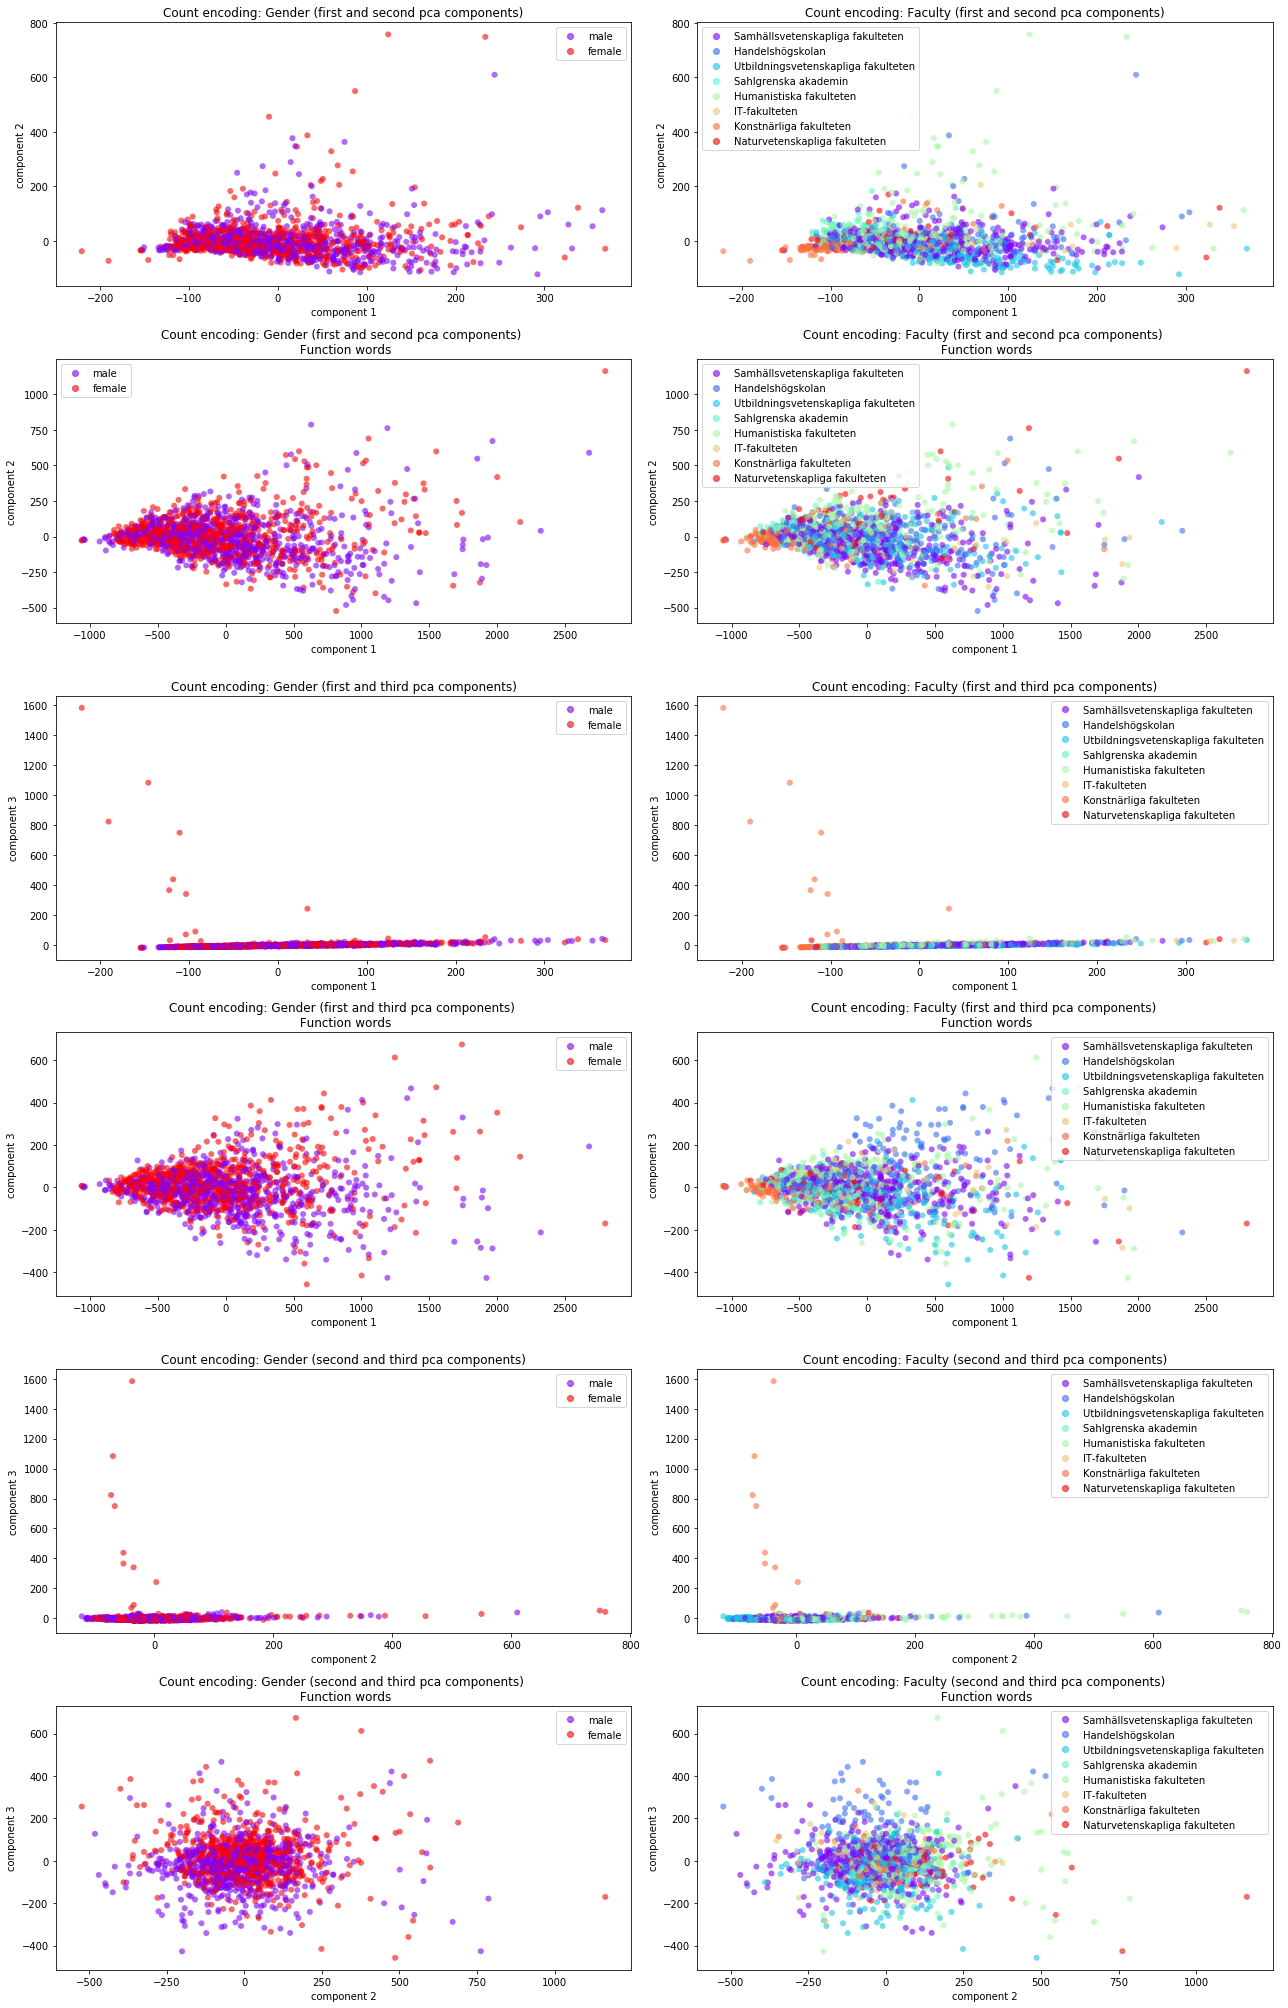

In [16]:
plot_pca_with_encoding('Count',pca_count_train,pca_count_train_fun)

In [18]:
from sklearn.linear_model import LogisticRegression

def fit_log_model(x,y) : 
    log_model = LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=1000)
    log_model.fit(x,y)
    return log_model



In [20]:
matrices_fun_fac = [[tokenizer.texts_to_matrix(doc,mode=mode) 
                 for mode in modes]
                for doc in docs_train_facs
               ]
#train_labels_i = [[train_labels_num[i] for i in indices[j]] for j in [0,1,2,3,4,5,6,7]]



    
#len(matrices_fun_fac[0][])
log_models_fun_binary = [fit_log_model(matrices_fun_fac[i][0],train_labels_i[i]) for i in range(len(train_labels_i))]
log_models_fun_tfidf = [fit_log_model(matrices_fun_fac[i][1],train_labels_i[i]) for i in range(len(train_labels_i))]
log_models_fun_count = [fit_log_model(matrices_fun_fac[i][2],train_labels_i[i]) for i in range(len(train_labels_i))]
log_models_fun_frequency = [fit_log_model(matrices_fun_fac[i][3],train_labels_i[i]) for i in range(len(train_labels_i))]

In [21]:
log_model_binary_fun    = fit_log_model(Xtrain_fun_binary,train_labels_num)
log_model_tfidf_fun     = fit_log_model(Xtrain_fun_tfidf,train_labels_num)
log_model_count_fun     = fit_log_model(Xtrain_fun_count,train_labels_num)
log_model_frequency_fun = fit_log_model(Xtrain_fun_freq,train_labels_num)


log_model_binary    = fit_log_model(Xtrain_binary,train_labels_num)
log_model_tfidf     = fit_log_model(Xtrain_tfidf,train_labels_num)
log_model_count     = fit_log_model(Xtrain_count,train_labels_num)
log_model_frequency = fit_log_model(Xtrain_freq,train_labels_num)


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [22]:

def load_doc(filename):
 # open the file as read only
 file = open(filename, 'r')
 # read all text
 text = file.read()
 text = text.split("\n")
 # close the file
 file.close()
 return text

tokens     = load_doc("vocab_equal_m_f.txt")
tokens_fun = load_doc("vocab_function.txt")


In [23]:

coefs_count         = log_model_count.coef_
coefs_count_fun     = log_model_count_fun.coef_

coefs_binary         = log_model_binary.coef_
coefs_binary_fun     = log_model_binary_fun.coef_

coefs_tfidf        = log_model_tfidf.coef_
coefs_tfidf_fun     = log_model_tfidf_fun.coef_

coefs_freq        = log_model_frequency.coef_
coefs_freq_fun     = log_model_frequency_fun.coef_


tokens = [a for (a,b) in tokenizer.word_index.items()]


tokens_fun = [a for (a,b) in tokenizer_fun.word_index.items()]

importances = [zip(tokens,coefs[0][1:]) 
                for coefs in [coefs_count,coefs_binary,coefs_tfidf,coefs_freq]]

importances_fun = [zip(tokens_fun,coefs[0][1:]) 
                     for coefs in [coefs_count_fun,coefs_binary_fun,coefs_tfidf_fun,coefs_freq_fun]]


sorted_importances = [sorted(importance, key=lambda x: abs(x[1]),reverse=True) 
                      for importance in importances]
sorted_importances_fun = [sorted(importance_fun, key=lambda x: abs(x[1]),reverse=True)
                          for importance_fun in importances_fun]
    

def get_important_words(sorted_importance,min_,max_) : 
    importance_1 = [(i,v) for (i,v) in sorted_importance if v > max_]
    importance_2 = [(i,v) for (i,v) in sorted_importance if v < min_]
    return (importance_1,importance_2)


important_count  = get_important_words(sorted_importances[0],-0.07,0.06)
important_binary = get_important_words(sorted_importances[1],-0.15,0.15)
important_tfidf  = get_important_words(sorted_importances[2],-0.05,0.05)
important_freq   = get_important_words(sorted_importances[3],-0.15,0.15)

important_count_fun  = get_important_words(sorted_importances_fun[0],-0.02,0.02)
important_binary_fun = get_important_words(sorted_importances_fun[1],-0.4,0.4)
important_tfidf_fun  = get_important_words(sorted_importances_fun[2],-0.2,0.2)
important_freq_fun   = get_important_words(sorted_importances_fun[3],-0.22,0.22)



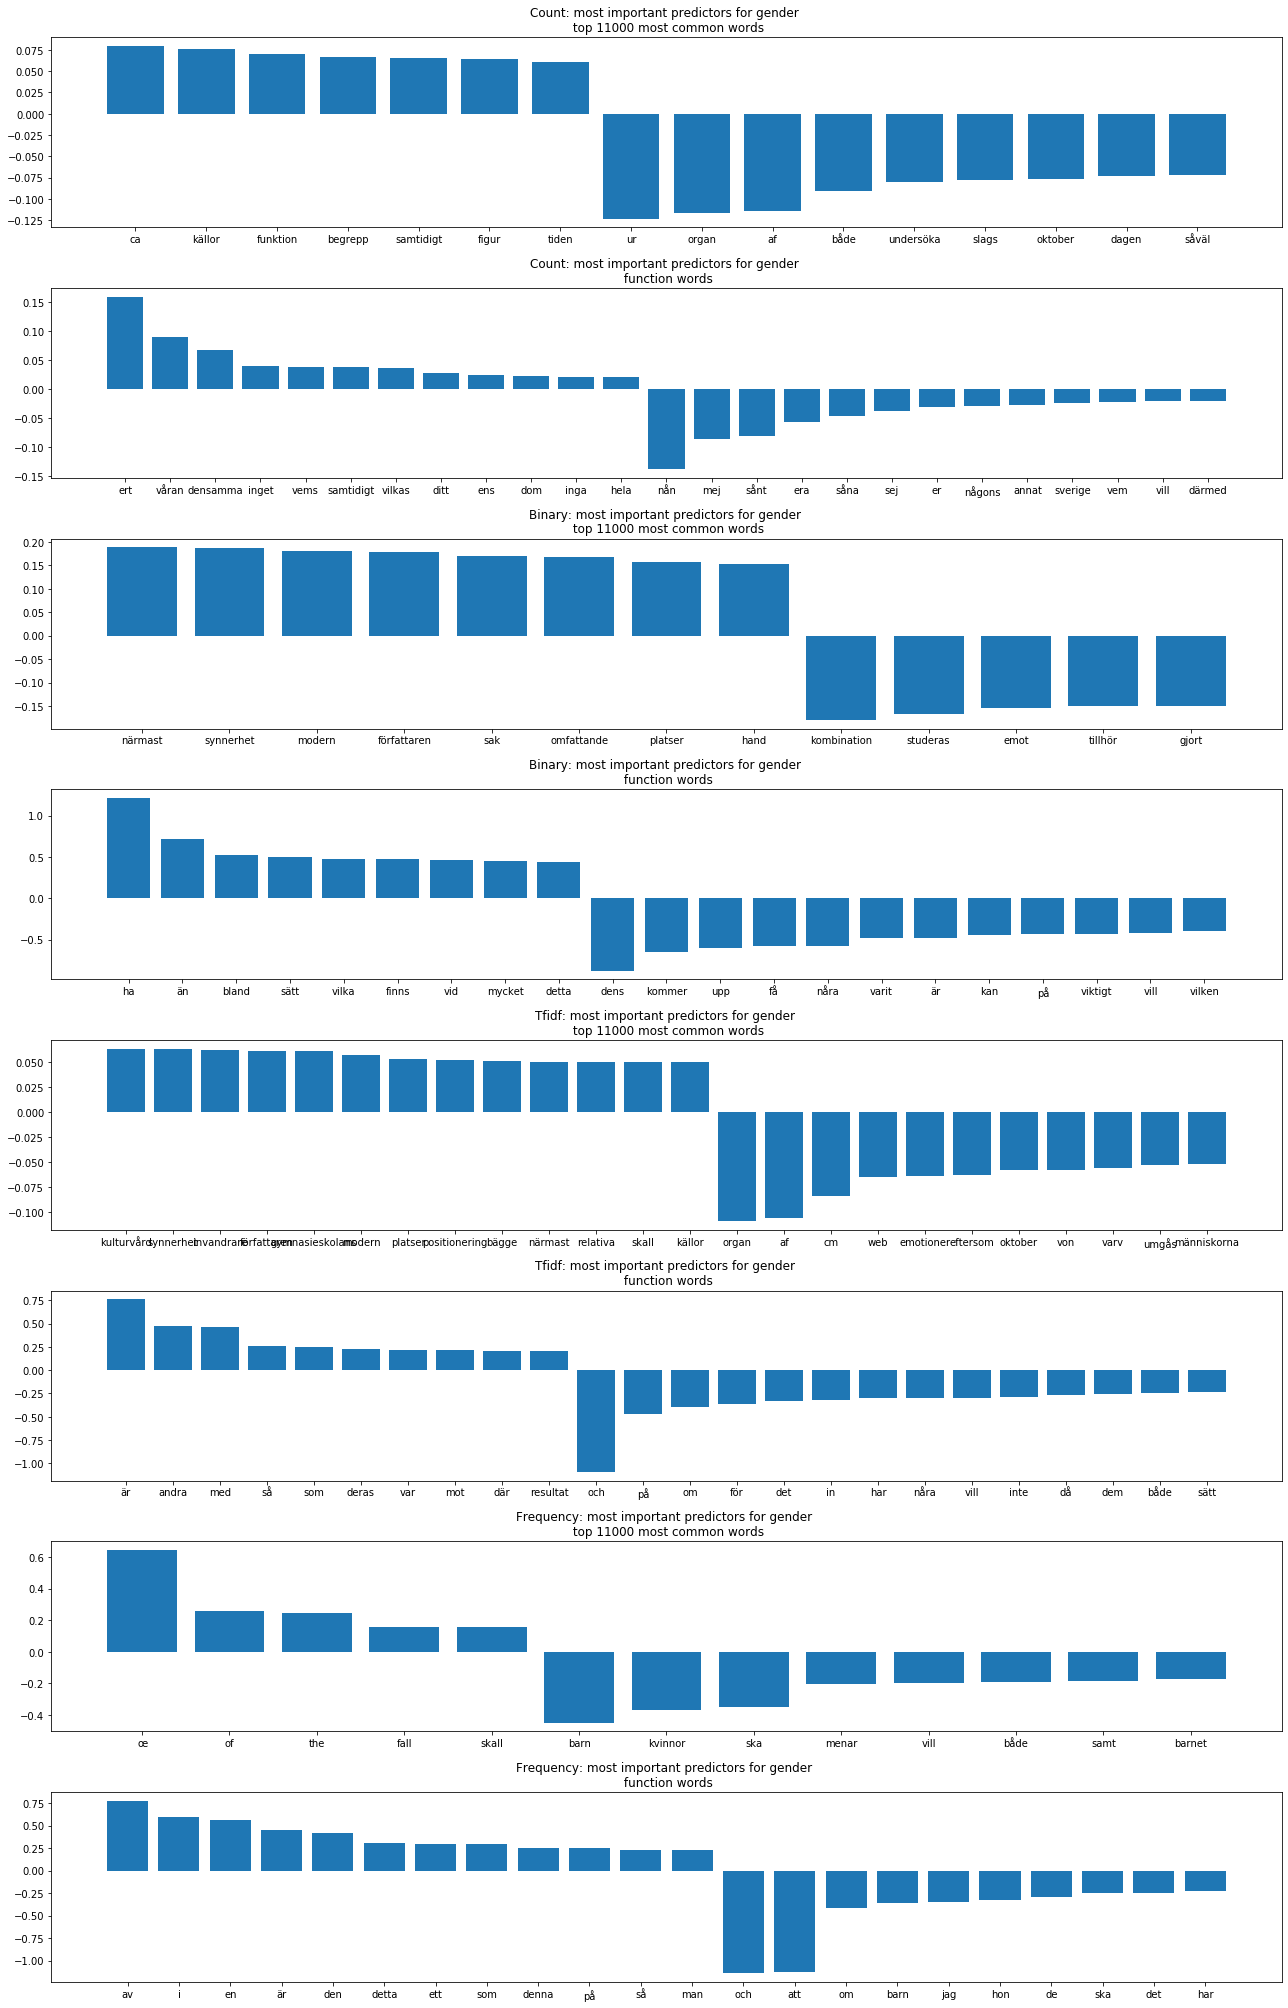

In [24]:
import matplotlib.pyplot as plt

n = 1
#fig = plt.figure(figsize=(18,28))
fig, ax = plt.subplots(figsize=(18,28))
for (important,important_fun,nam) in [(important_count, important_count_fun,"Count"),(important_binary, important_binary_fun, "Binary"),
                        (important_tfidf, important_tfidf_fun,"Tfidf"),(important_freq,important_freq_fun,"Frequency")] :
    
    
    #fig = plt.figure(figsize=(18,28))
    plt.subplot(8, 1, n)
    
    y_pos = [i for (i,v) in important[0] + important[1]] # ,important_count[1]
    columns = [v for (i,v) in important[0] + important[1]]

    plt.bar(y_pos, columns)
    plt.xticks(y_pos, y_pos,)
    plt.title(nam + ": most important predictors for gender \n top 11000 most common words")
 #   plt.show()
    
    plt.subplot(8, 1, n+1) 
    y_pos = [i for (i,v) in important_fun[0] + important_fun[1]] # ,important_count[1]
    columns = [v for (i,v) in important_fun[0] + important_fun[1]]
   
    plt.bar(y_pos, columns)
    plt.xticks(y_pos, y_pos,)
    plt.title(nam + ": most important predictors for gender \n function words")
    n = n + 2
    
plt.tight_layout()
plt.show()

In [25]:
coefs_fun_count = [log_models_fun_count[i].coef_ for i in range(8)]

importances_fun_count = [zip(tokens_fun,coefs_fun_count[i][0][1:]) 
                     for i in range(len(coefs_fun_count))]

sorted_importances_fun_count = [sorted(importance_fun, key=lambda x: abs(x[1]),reverse=True)
                          for importance_fun in importances_fun_count]

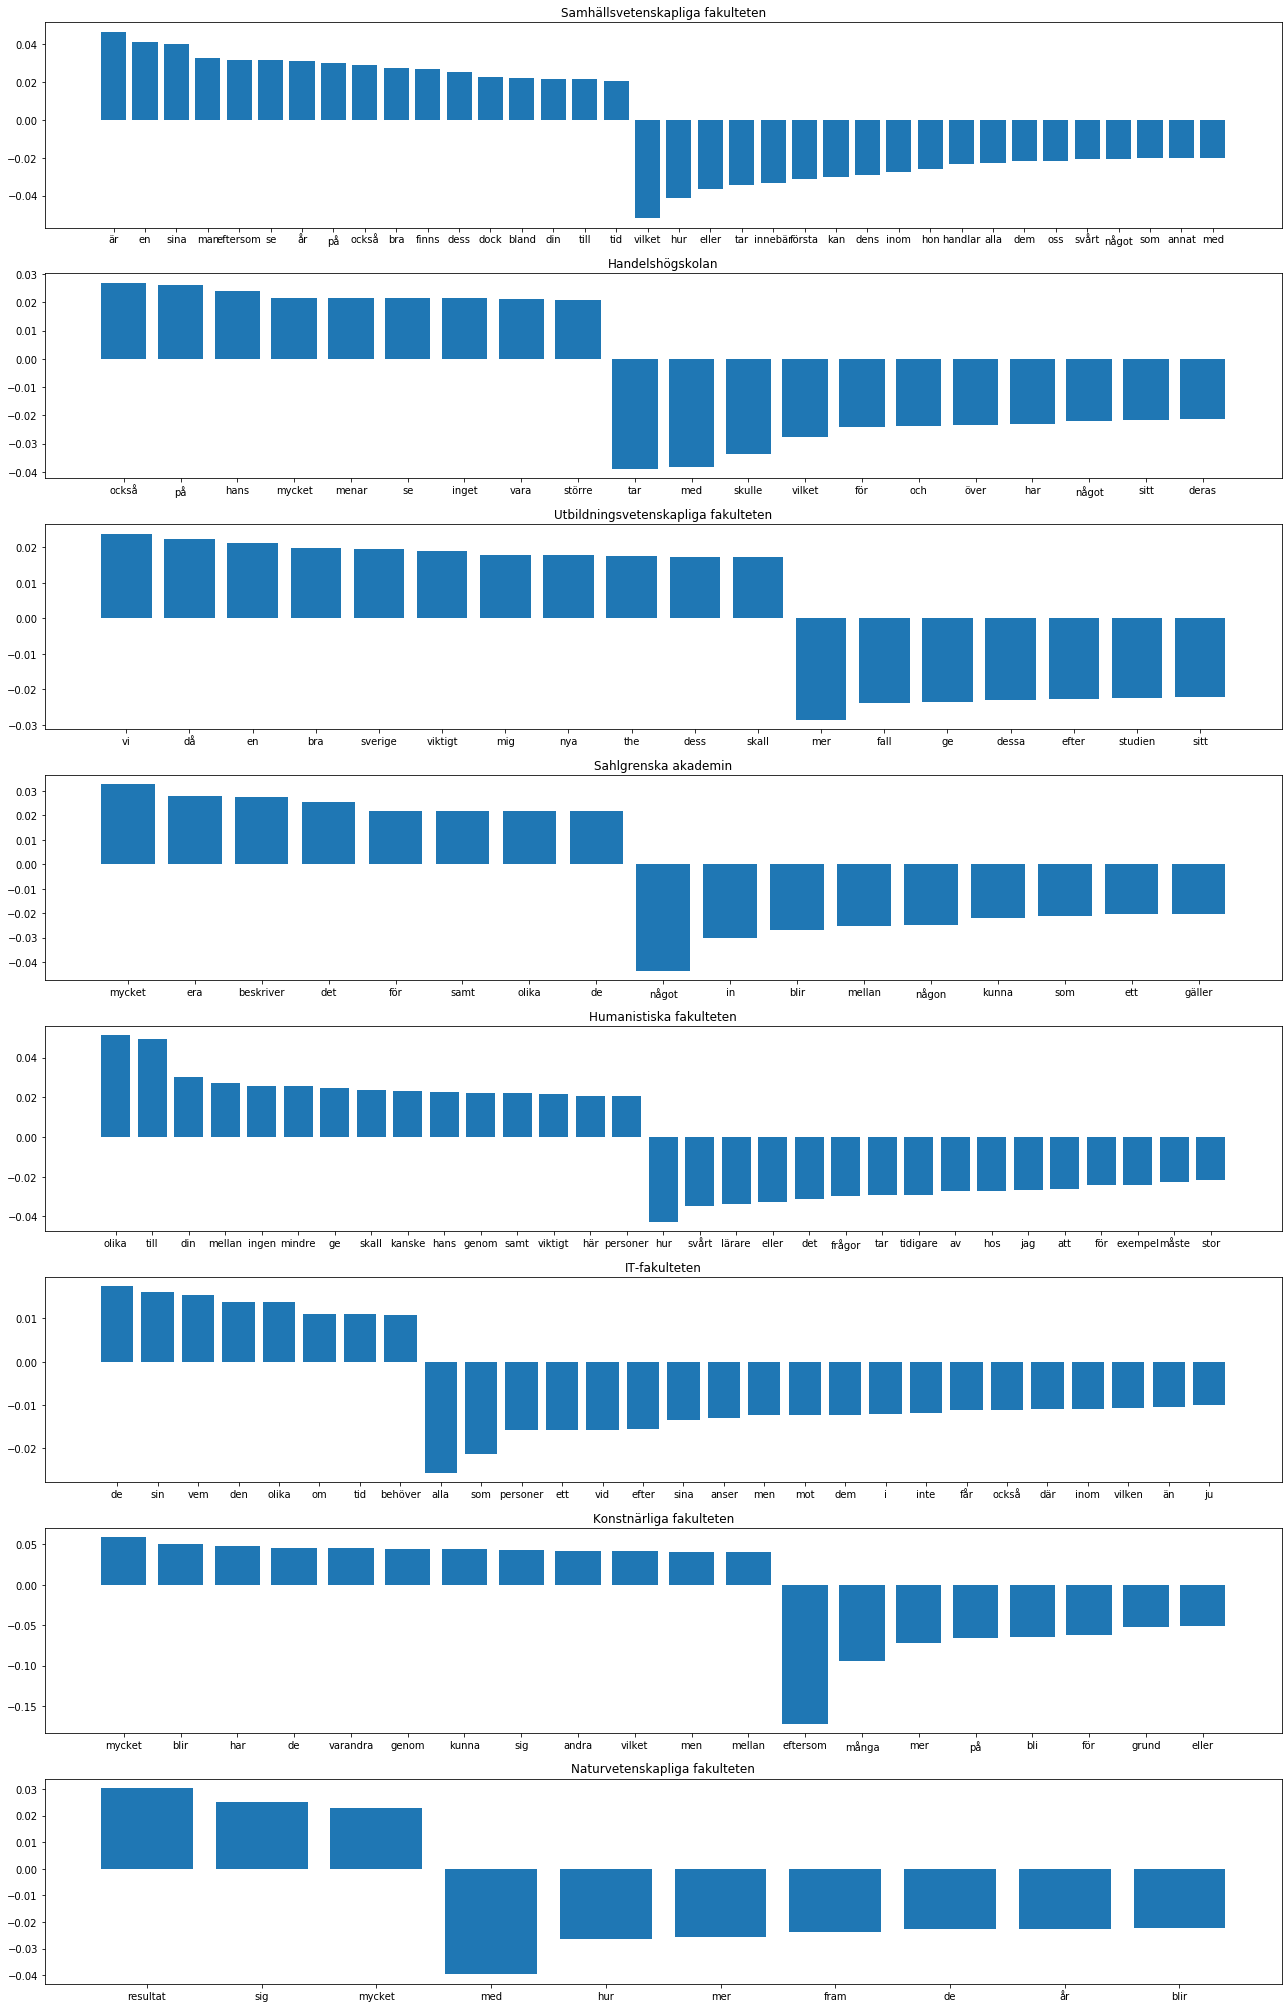

In [26]:
mins = [-0.02,-0.02,-0.022,-0.02,-0.02,-0.01,-0.05,-0.02]
maxs = [0.02,0.02,0.017,0.02,0.02,0.01,0.04,0.02]

importants  = [get_important_words(sorted_importances_fun_count[i],mins[i],maxs[i]) for i in range(8)]

fig, ax = plt.subplots(figsize=(18,28))
for i in range(len(importants)) :
    plt.subplot(8, 1, i+1)
    plt.title(faculties[i])
    y_pos = [i for (i,v) in importants[i][0] + importants[i][1]] # ,important_count[1]
    columns = [v for (i,v) in importants[i][0] + importants[i][1]]
    
    plt.bar(y_pos, columns)
    plt.xticks(y_pos, y_pos,)
plt.tight_layout()
plt.show()

        



In [27]:
log_model_binary_pca = fit_log_model(pca_binary_train[:,[0,2]],train_labels_num)
log_model_tfidf_pca  = fit_log_model(pca_tfidf_train[:,[0,2]],train_labels_num)
log_model_count_pca  = fit_log_model(pca_count_train[:,[0,2]],train_labels_num)
log_model_freq_pca   = fit_log_model(pca_freq_train[:,[0,2]],train_labels_num)



In [28]:
log_model_binary_pca_fun = fit_log_model(pca_binary_train_fun[:,[0,2]],train_labels_num)#fit_log_model(pca_binary_train[:,[0,2]],train_labels_num)
log_model_tfidf_pca_fun  = fit_log_model(pca_tfidf_train_fun[:,[0,2]],train_labels_num)#fit_log_model(pca_tfidf_train[:,[0,2]],train_labels_num)
log_model_count_pca_fun  = fit_log_model(pca_count_train_fun[:,[0,2]],train_labels_num)#fit_log_model(pca_count_train[:,[0,2]],train_labels_num)
log_model_freq_pca_fun   = fit_log_model(pca_freq_train_fun[:,[0,2]],train_labels_num) #fit_log_model(pca_freq_train[:,[0,2]],train_labels_num)


In [29]:
from sklearn.metrics import accuracy_score

def print_accuracy_scores(model,train,val,mode) : 
    print("Accuracy scores for training and validation data: " + mode + " encoding")
    print(accuracy_score(train_labels_num, model.predict(train)))
    print(accuracy_score(val_labels_num, model.predict(val)))

    


In [30]:
print_accuracy_scores(log_model_binary,Xtrain_binary,Xval_binary,"Binary ")
print_accuracy_scores(log_model_tfidf,Xtrain_tfidf,Xval_tfidf,"Tfidf ")
print_accuracy_scores(log_model_frequency,Xtrain_freq,Xval_freq,"Frequency ")
print_accuracy_scores(log_model_count,Xtrain_count,Xval_count,"Count ")

Accuracy scores for training and validation data: Binary  encoding
1.0
0.7231075697211156
Accuracy scores for training and validation data: Tfidf  encoding
1.0
0.7091633466135459
Accuracy scores for training and validation data: Frequency  encoding
0.6055776892430279
0.547808764940239
Accuracy scores for training and validation data: Count  encoding
1.0
0.6772908366533864


In [31]:


print_accuracy_scores(log_model_binary_pca,pca_binary_train[:,[0,2]],pca_binary_val[:,[0,2]],"PCA Binary ")
print_accuracy_scores(log_model_tfidf_pca,pca_tfidf_train[:,[0,2]],pca_tfidf_val[:,[0,2]],"PCA Tfidf ")
print_accuracy_scores(log_model_freq_pca,pca_freq_train[:,[0,2]],pca_freq_val[:,[0,2]],"PCA Frequency ")
print_accuracy_scores(log_model_count_pca,pca_count_train[:,[0,2]],pca_count_val[:,[0,2]],"PCA Count ")

Accuracy scores for training and validation data: PCA Binary  encoding
0.5571049136786188
0.549800796812749
Accuracy scores for training and validation data: PCA Tfidf  encoding
0.5312084993359893
0.5438247011952191
Accuracy scores for training and validation data: PCA Frequency  encoding
0.5046480743691899
0.4800796812749004
Accuracy scores for training and validation data: PCA Count  encoding
0.5584329349269588
0.5737051792828686


In [32]:

print_accuracy_scores(log_model_binary_fun,Xtrain_fun_binary,Xval_fun_binary,"Function words - binary")
print_accuracy_scores(log_model_tfidf_fun,Xtrain_fun_tfidf,Xval_fun_tfidf,"Function words - Tfidf")
print_accuracy_scores(log_model_frequency_fun,Xtrain_fun_freq,Xval_fun_freq,"Function words - Frequency")
print_accuracy_scores(log_model_count_fun,Xtrain_fun_count,Xval_fun_count,"Function words - Count")


Accuracy scores for training and validation data: Function words - binary encoding
0.7051792828685259
0.5717131474103586
Accuracy scores for training and validation data: Function words - Tfidf encoding
0.7675962815405046
0.701195219123506
Accuracy scores for training and validation data: Function words - Frequency encoding
0.6168658698539177
0.5916334661354582
Accuracy scores for training and validation data: Function words - Count encoding
0.7636122177954847
0.6593625498007968


In [33]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
def plot_decision_boundary(model,train,val,labels) : 
    
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = train.min() , train.max() # + .5
    y_min, y_max = train.min() , train.max() # + .5

    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
 
    plt.scatter(val[:,0], val[:,1], c=labels, edgecolors='k', cmap=plt.cm.Paired)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()


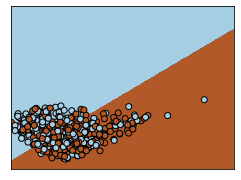

In [34]:

plot_decision_boundary(log_model_binary_pca_fun,pca_binary_train_fun[:,[0,2]],pca_binary_val_fun[:,[0,2]],val_labels_num)



In [ ]:
#plot_decision_boundary(log_model_count_pca_fun,pca_count_train_fun[:,[0,2]],pca_count_val_fun[:,[0,2]],val_labels_num)

In [ ]:
#plot_decision_boundary(log_model_tfidf_pca,pca_tfidf_train[:,[0,2]],pca_tfidf_val[:,[0,2]],val_labels_num)

In [ ]:

#plot_decision_boundary(log_model_tfidf_pca,pca_tfidf_train[:,[0,2]],pca_tfidf_train[:,[0,2]],train_labels_num)